# 🐶🐱 Cat and Dog Image Classifier
### My Solution to a freeCodeCamp Project

This Colab notebook is my solution to the **Cat and Dog Image Classifier** project from [freeCodeCamp.org](https://www.freecodecamp.org/).  
🔗 [View the original project page here](https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/cat-and-dog-image-classifier)

The task is to build a convolutional neural network (CNN) that can classify images as either cats or dogs.

**Note**: Dataset and some boilerplate setup code were provided by freeCodeCamp.  
**All model design, training code, and additional enhancements were written by me.**


### Load Dataset (Provided)
This section was included as boilerplate by freeCodeCamp to help with dataset loading.

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epoch_num = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

## Image Data Generators and Preprocessing

In this section, I created image data generators to preprocess and feed the images into the model.

- All images are rescaled by `1./255` to normalize pixel values between 0 and 1.
- **Training data** is shuffled each epoch to improve generalization and reduce overfitting.
- `class_mode='binary'` is used since this is a binary classification problem (cat vs. dog).
- **Validation data** is not shuffled and is used to monitor performance during training.
- **Test data** is loaded without labels (`class_mode=None`) and not shuffled, since it is used strictly for prediction and evaluation. The `classes=['.']` setting ensures that the generator processes all images in the root of the test directory without subfolders.


In [3]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    )
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)


train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# No shuffle because this is the set we are testing on
test_data_gen = test_image_generator.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    classes=['.']
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


## Image Preview Function (Provided)

This utility function was provided to visualize sample images from the dataset.

- `plotImages()` displays a vertical stack of images using Matplotlib.
- If `probabilities` is set to `False`, the function simply shows the images with no labels.
- If prediction probabilities are passed, it labels each image with the predicted class and confidence (e.g., "85% dog").
- `sample_training_images, _ = next(train_data_gen)` retrieves a batch of training images to preview the first few.

This helps ensure the data is being loaded and preprocessed correctly before training begins.


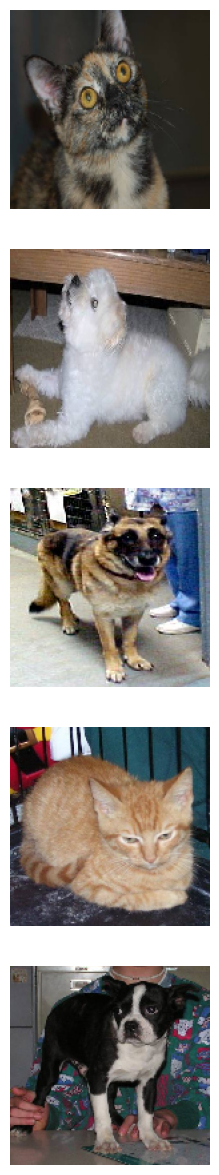

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


##  Data Augmentation for Training Images

To help the model generalize better and avoid overfitting, I applied data augmentation to the training images using `ImageDataGenerator`.

The following transformations are applied:
- `rescale=1./255`: Normalizes pixel values to the [0, 1] range.
- `rotation_range=40`: Randomly rotates images by up to 40 degrees.
- `width_shift_range` & `height_shift_range`: Randomly shifts images horizontally and vertically by 20%.
- `shear_range=0.2`: Applies shear transformations.
- `zoom_range=0.2`: Randomly zooms in on images.
- `horizontal_flip=True`: Randomly flips images left-to-right.
- `fill_mode='nearest'`: Fills in new pixels created during transformations.

This helps create a more robust training set from the limited data available.


In [5]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,       # Random rotation (degrees)
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest'      # Fill strategy for new pixels
    )


## Visualizing Augmented Training Images (Provided)

This section uses a data generator to load and augment images from the training directory:

- `flow_from_directory()` loads images from `train_dir` with the specified `target_size`, `batch_size`, and binary class mode.
- A batch is sampled using `train_data_gen[0]`, and five augmented images are extracted.
- `plotImages()` is then used to display the augmented images and visually confirm that transformations such as rotation, shifting, zooming, and flipping are being applied correctly.

This code was provided by freeCodeCamp as part of the project boilerplate.


Found 2000 images belonging to 2 classes.


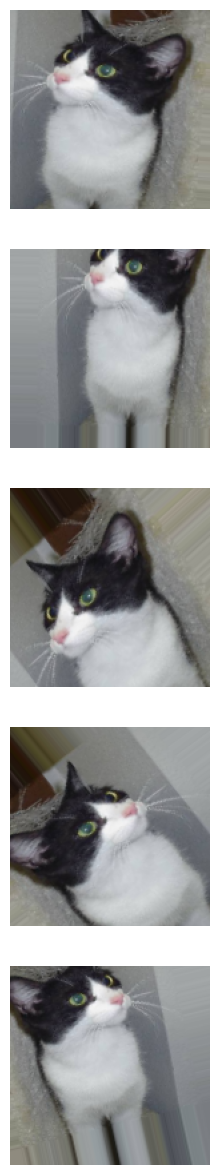

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

## Convolutional Neural Network Architecture

This section defines the convolutional neural network used for binary image classification (cats vs. dogs). The model is built using Keras' `Sequential` API and consists of the following:

- **5 convolutional layers** (`Conv2D`) with ReLU activation and `same` padding to preserve spatial dimensions.
- **4 max pooling layers** (`MaxPooling2D`) to reduce spatial size and extract dominant features.
- A **flattening layer** to convert the final feature maps into a 1D vector.
- A **dense layer** with 64 units and ReLU activation for learning non-linear combinations of features.
- A **dropout layer** to reduce overfitting by randomly dropping 50% of the units during training.
- A final **dense output layer** with a sigmoid activation function to output a probability for binary classification.

The model summary is printed at the end to display the architecture and number of parameters.


In [7]:
# 7
model = Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,905 (796.50 KB)

 Trainable params: 203,905 (796.50 KB)

 Non-trainable params: 0 (0.00 B)

## Early Stopping Callback

An `EarlyStopping` callback is used to monitor validation loss.  
- Training stops if the validation loss does not improve after 5 consecutive epochs (`patience=5`).
- The model will restore the weights from the epoch with the best validation loss.


In [8]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## Model Compilation

The model is compiled with:
- `Adam` optimizer for efficient gradient descent.
- `binary_crossentropy` loss function for binary classification.
- `accuracy` as the evaluation metric.

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Model Training

The model is trained using the training and validation data generators.  
- Runs for a set number of epochs (`epoch_num`) or until early stopping is triggered.  
- Uses the `early_stop` callback to prevent overfitting.


In [10]:
# 8
history = model.fit(train_data_gen, validation_data=val_data_gen, batch_size=batch_size, epochs=epoch_num, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4997 - loss: 0.6961 - val_accuracy: 0.5520 - val_loss: 0.6927
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 894ms/step - accuracy: 0.5048 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6906
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 900ms/step - accuracy: 0.5148 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6891
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 884ms/step - accuracy: 0.5107 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.6895
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 887ms/step - accuracy: 0.5200 - loss: 0.6903 - val_accuracy: 0.6360 - val_loss: 0.6781
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 888ms/step - accuracy: 0.5558 - loss: 0.6817 - val_accuracy: 0.6560 - val_loss: 0.6402
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 880ms/step - accuracy: 0.5956 - loss: 0.6689 - val_accuracy: 0.5840 - val_loss: 0.6670
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 888ms/step - accuracy: 0.6177 - loss: 0.6677 - val_accurac

## Training History Visualization (Provided)

This section plots the training and validation accuracy and loss over epochs.

- Extracts accuracy and loss metrics from the `history` object.
- Uses `matplotlib` to generate side-by-side plots:
  - Left: Training vs. validation accuracy.
  - Right: Training vs. validation loss.
- Helps visualize model performance and identify overfitting or underfitting trends.

This code was provided by freeCodeCamp as part of the project template.


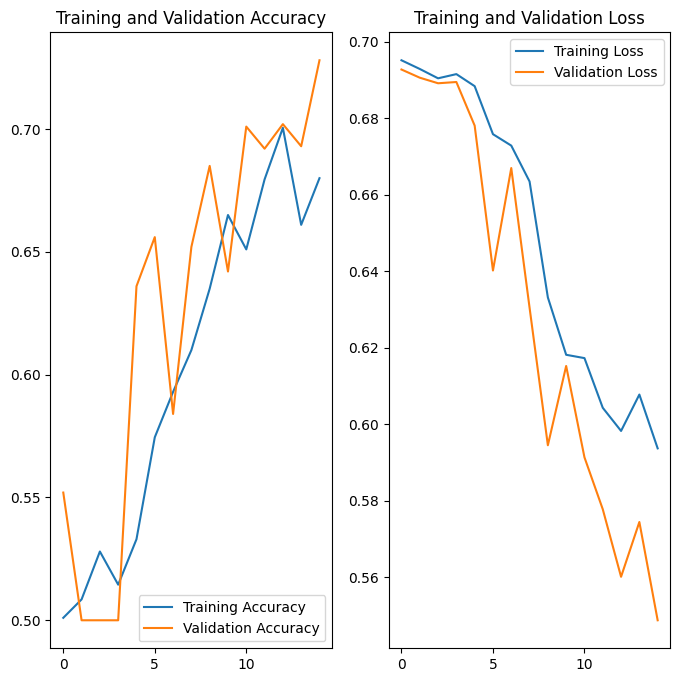

In [11]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Generating Predictions on Test Data

This line uses the trained model to predict probabilities on the test dataset.  
- The test data is passed through the model in batches using `test_data_gen`.  
- The output is a list of probabilities indicating the likelihood that each image is a dog (`> 0.5`) or a cat (`< 0.5`).


In [12]:
probabilities = model.predict(test_data_gen, batch_size=batch_size, verbose='auto')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


## Challenge Evaluation Logic (Provided)

This block evaluates the model's performance on the test set using predefined labels (`answers`).

- Each predicted probability is rounded to 0 or 1 and compared to the correct answer.
- The percentage of correctly identified images is calculated.
- If accuracy is at least 63%, the model is considered to have passed the challenge.

This evaluation logic and the ground truth labels were provided by freeCodeCamp.


In [13]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability[0]) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!
